# Hybrid methods

1. Feature Shuffling
2. Recursive feature elimination
3. Recursive feature addition

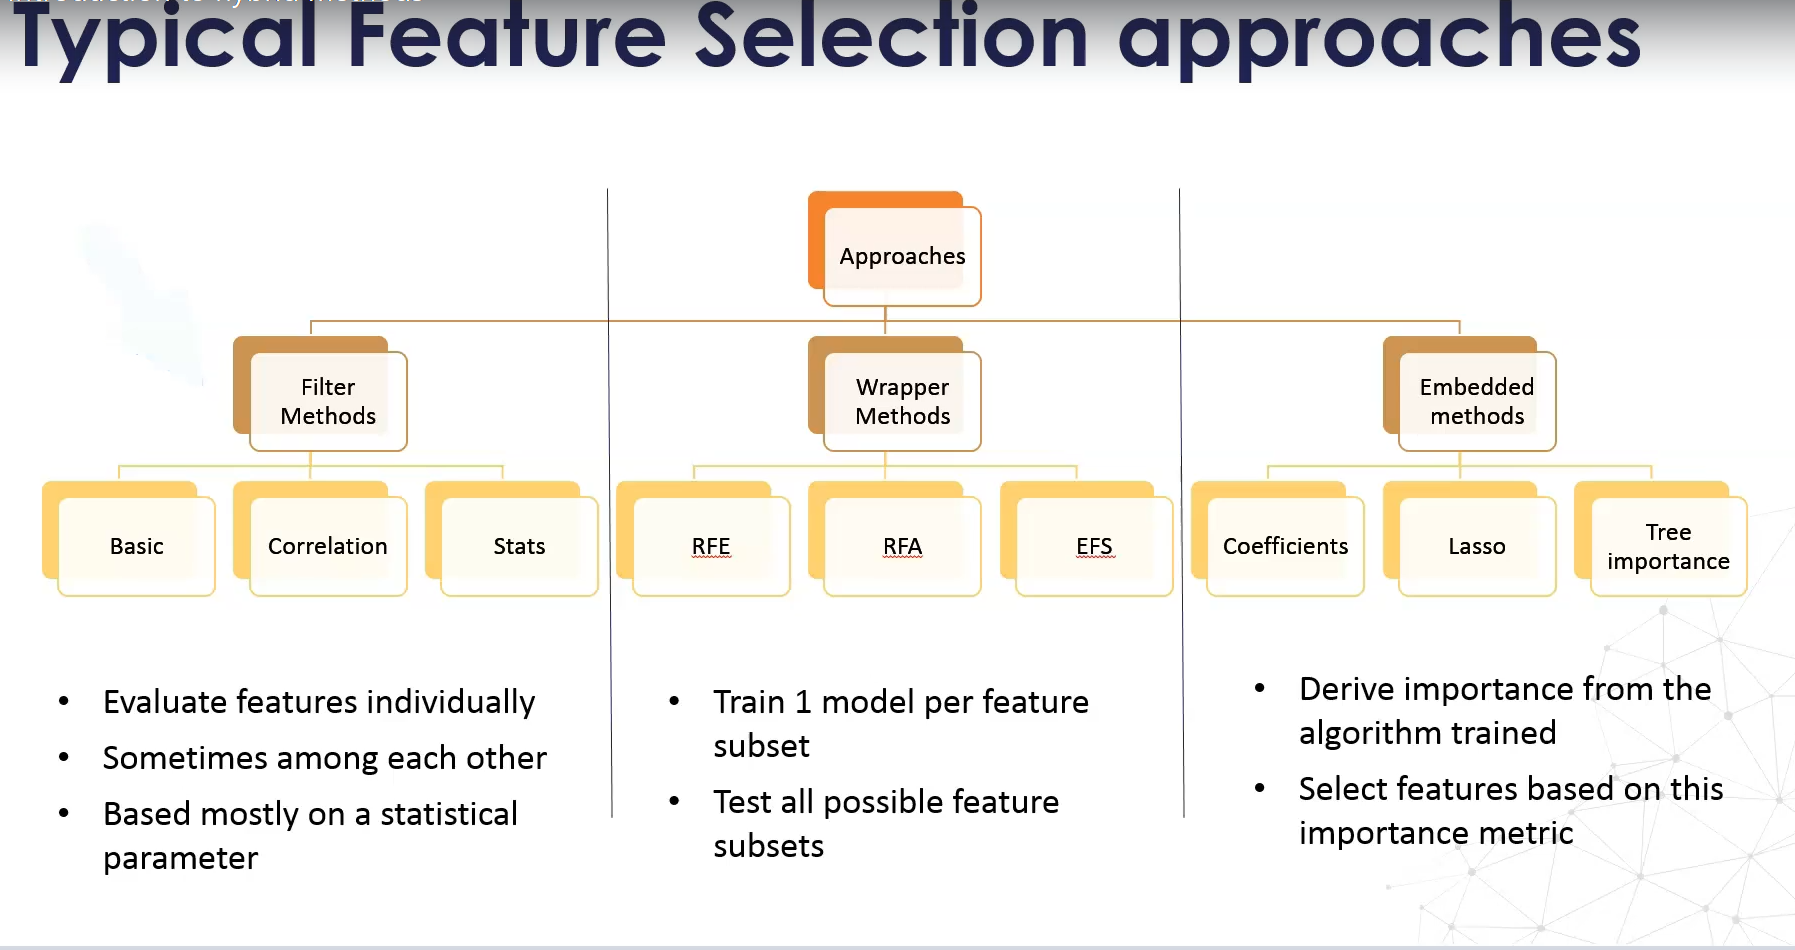

# Feature Shuffling

## Feature Selection by Random Shuffling

A popular method of feature selection consists in random shuffling the values of a specific variable and determining how that permutation affects the performance metric of the machine learning algorithm. In other words, the idea is to permute the values of each feature, one feature at the time, and measure how much the permutation (or shuffling of its values) decreases the accuracy, or the roc_auc, or the mse of the machine learning model (or any other performance metric!). If the variables are important, a random permutation of their values will decrease dramatically any of these metrics. Contrarily, the permutation or shuffling of values should have little to no effect on the model performance metric we are assessing.

The procedure goes more or less like this:

- Build a machine learning model and store its performance metric
- Shuffle 1 feature, and make a new prediction using the previous model
- Determine the performance of this prediction
- Determine the change in the performance of the prediction with the shuffled feature vs the original one
- Repeat for each feature

To select features, we choose those that induced a decrease in model performance, beyond an arbitrarily set threshold.

I will demonstrate how to select features based on random shuffling using on a regression and classification problem. 

**Note** For the demonstration, I will continue to use Random Forests, but this selection procedure can be used with machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

## Classification

In [ ]:
# load dataset
data = pd.read_csv('../dataset_2.csv')
data.shape

In [ ]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

In [ ]:
# for this method, it is necessary to reset the indeces of the returned 
# datasets

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### Train ML algo with all features

In [ ]:
# The first step to determine feature importance by feature shuffling
# is to build the machine learning model for which we want to 
# select features

# In this case, I will build Random Forests, but remember that 
# you can use this procedure with any other machine learning algorithm

# I build few and shallow trees to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:, 1]))

### Shuffle features and asses performance drop

In [2]:
# in this cell, I will shuffle one by one, each feature of the dataset

# then I use the dataset with the shuffled variable to make predictions
# with the random forests I trained in the previous cell

# overall train roc-auc: using all the features
train_roc = roc_auc_score(y_train, (rf.predict_proba(X_train))[:, 1])

# list to capture the performance shift
performance_shift = []

# selection  logic
for feature in X_train.columns:

    X_train_c = X_train.copy()

    # shuffle individual feature
    X_train_c[feature] = X_train_c[feature].sample(
        frac=1, random_state=10).reset_index(drop=True)

    # make prediction with shuffled feature and calculate roc-auc
    shuff_roc = roc_auc_score(y_train, rf.predict_proba(X_train_c)[:, 1])
    
    drift = train_roc - shuff_roc

    # save the drop in roc-auc
    performance_shift.append(drift)

NameError: name 'y_train' is not defined

In [ ]:
# le't have a look at our list of performances
performance_shift

In [ ]:
# Now I will transform the list into a pandas Series
# for easy manipulation

feature_importance = pd.Series(performance_shift)

# add variable names in the index
feature_importance.index = X_train.columns

feature_importance.head()

In [ ]:
# Now I will sort the dataframe according to the drop in performance
# caused by feature shuffling

feature_importance.sort_values(ascending=False)

In [ ]:
# visualise the top 10 features that caused the major drop
# in the roc-auc (aka model performance)

feature_importance.sort_values(ascending=False).head(10)

In [ ]:
# original number of features (rows in this case)
feature_importance.shape[0]

In [ ]:
# number of features that cause a drop in performance
# when shuffled

feature_importance[feature_importance>0].shape[0]

Only 30 out of the 108 features caused a drop in the performance of the random forests when their values were permuted. This means that we could select those features and discard the rest, and should keep the original random forest performance. 

In [ ]:
# print the important features

feature_importance[feature_importance>0].index

### Select features

In [ ]:
# Now let's build a random forests only with the selected features

# capture the selected features
selected_features = feature_importance[feature_importance > 0].index

# train a new random forests using only the selected features
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=2,
                            random_state=2909,
                            n_jobs=4)

rf.fit(X_train[selected_features], y_train)

# print roc-auc in train and testing sets
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train[selected_features]))[:,
                                                                          1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test[selected_features]))[:, 1]))